<a href="https://colab.research.google.com/github/jp-quevedo/data-science-nlp/blob/main/ds_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acerca del proyecto

### **Introducción**

Este dataset proporciona "tweets fuente" etiquetados de los datasets Twitter15 y Twitter16, que son comúnmente utilizados en la investigación sobre la detección de rumores y la clasificación de desinformación. Cada tweet fuente está categorizado como un rumor o no rumor, lo que lo hace adecuado para entrenar modelos supervisados en tareas de clasificación binaria.

El dataset se centra en tweets fuente, omitiendo la interacción de hilos de conversación o metadatos adicionales, con el fin de facilitar un enfoque directo para entender la relación entre el contenido del tweet y la clasificación de rumor.

### **Categorías de tweet fuente**

* **non-rumor** (579 entradas): No es un rumor
* **true** (579 entradas): Rumor verdadero
* **unverified** (575 entradas): Rumor sin verificar
* **false** (575 entradas): Rumor falso

### **Motivación y objetivo del proyecto**

Mi motivación principal yace en el potencial de limpieza que tiene el dataset. Ejecutaré un preprocesamiento y análisis efectivo del dataset, a través del uso de distintas librerías como Pandas, Regex, Matplotlib, Sklearn, NLTK, Spacy, Wordcloud, entre otras. Buscaré desarrollar un modelo predictivo de alto rendimiento para predicción de categorías de tweets fuente.

# Importe de librerías

In [227]:
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

!python -m spacy download en_core_web_sm
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importe del dataset y análisis básico

In [200]:
# Fuente del dataset: https://www.kaggle.com/datasets/syntheticprogrammer/rumor-detection-acl-2017?resource=download

label15 = pd.read_csv('https://github.com/jp-quevedo/data-science-nlp/raw/refs/heads/main/label15.txt', delimiter = '\t', header = None)
label16 = pd.read_csv('https://github.com/jp-quevedo/data-science-nlp/raw/refs/heads/main/label16.txt', delimiter = '\t', header = None)
source15 = pd.read_csv('https://github.com/jp-quevedo/data-science-nlp/raw/refs/heads/main/source_tweets15.txt', delimiter = '\t', header = None)
source16 = pd.read_csv('https://github.com/jp-quevedo/data-science-nlp/raw/refs/heads/main/source_tweets16.txt', delimiter = '\t', header = None)

# El dataset está dividido en 4 archivos, separados por año (2015 y 2016) y por claves (label = y, source = x)
# Combinaré los archivos para trabajar con un set más grande (esta fusión logra un total de 2308 filas)

# Concatenaré los archivos por clave
full_label = pd.concat([label15, label16], ignore_index=True)
full_source = pd.concat([source15, source16], ignore_index=True)

# Limpiaré los valores de full_label[0]
def clean_value(value):
    if isinstance(value, str) and ':' in value:
        return value.split(':')[0]
    return value

full_label[0] = full_label[0].apply(clean_value)

# Reemplazaré los valores de full_source[0] con los valores de full_label[0] y cambiaré el nombre de las columnas
full_source[0] = full_label[0].values
df = full_source.rename(columns={0: 'y', 1: 'X'})

df.head()

,y,X
0,unverified,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
1,unverified,an open letter to trump voters from his top st...
2,non-rumor,america is a nation of second chances —@potus ...
3,non-rumor,"brandon marshall visits and offers advice, sup..."
4,true,rip elly may clampett: so sad to learn #beverl...


In [201]:
df.isnull().sum()

,0
y,0
X,0


In [202]:
df['y'].value_counts()

,count
y,
non-rumor,579
true,579
unverified,575
false,575


# Regex

In [203]:
# Limpiaré los valores de df['X'] con regex entre otras herramientas
def clean_text(text):
    if isinstance(text, str):
        # a minúsculas
        text = text.lower()
        # hashtags
        text = re.sub(r'#\w+', '', text)
        # menciones de usuarios
        text = re.sub(r'@\w+', '', text)
        # emojis y caracteres no alfanuméricos excepto espacios y comas
        text = re.sub(r'[^\w\s,]', '', text)
        # URL
        text = re.sub(r'\burl\b', '', text)
        # números aislados
        text = re.sub(r'\b\d+\b', '', text)
        # caracteres especiales no alfabéticos
        text = re.sub(r'[^a-z\s]', '', text)
    return text

df['X'] = df['X'].apply(clean_text)

# Eliminaré la palabra "URL" presente en todas las entradas y las filas que contengan carácteres no pertenecientes a ASCII, ya que no aportan valor
#df['X'] = df['X'].str.replace(r'\bURL\b', '', regex = True)
df = df[df['X'].apply(lambda x: isinstance(x, str) and x.isascii())]

# Resetearé la indexación tras la eliminación de filas sin información de valor
df = df.reset_index(drop = True)

df.head()

,y,X
0,unverified,ca kkk grand wizard endorses
1,unverified,an open letter to trump voters from his top st...
2,non-rumor,america is a nation of second chances on new ...
3,non-rumor,brandon marshall visits and offers advice supp...
4,true,rip elly may clampett so sad to learn star do...


# Spacy, Matplotlib y Wordcloud

## Tokens y Stopwords

In [204]:
# Eliminaré las stopwords y palabras de menos de 3 letras para tener una mejor calidad informativa en el vocabulario
df['X_spacy'] = df['X'].apply(lambda text: [token.text for token in nlp(text)
                                                   if not token.is_stop and token.text.strip() != '' and len(token.text) >= 3])

df[['y', 'X_spacy']].head()

,y,X_spacy
0,unverified,"[kkk, grand, wizard, endorses]"
1,unverified,"[open, letter, trump, voters, strategistturned..."
2,non-rumor,"[america, nation, second, chances, new, reform..."
3,non-rumor,"[brandon, marshall, visits, offers, advice, su..."
4,true,"[rip, elly, clampett, sad, learn, star, donna,..."


## Wordcloud y POS-Tagging

132120


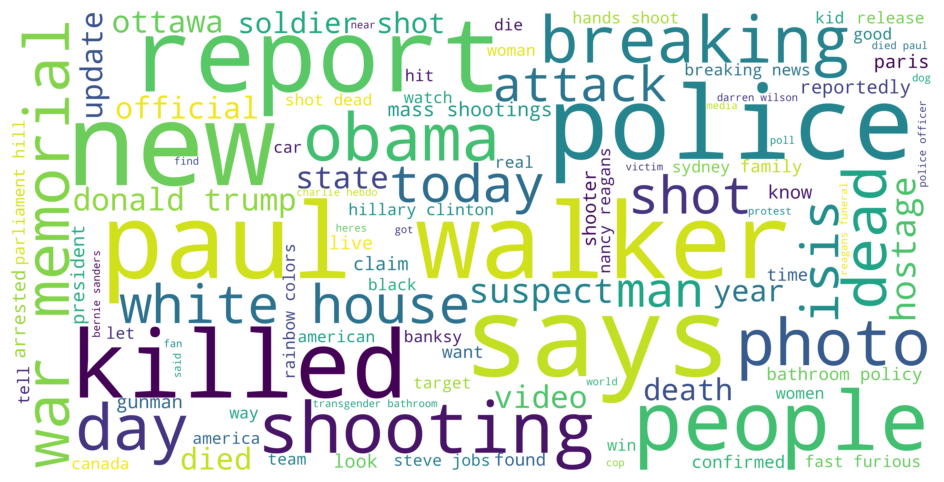

In [205]:
# Uniré las listas de tokens en un solo texto
word_cloud_text = ' '.join(df['X_spacy'].apply(lambda x: ' '.join(x)))

# longitud del texto generado
print(len(word_cloud_text))

# Crearé la wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [206]:
def procesar_tokens(token_list):
    doc = nlp(' '.join(token_list))
    for token in doc:
        print(token, ' -', token.tag_, ' -', token.pos_, ' -', spacy.explain(token.tag_))

# df['X_spacy'].apply(procesar_tokens)

# Esta aplicación tomó +1 minuto en ejecutarse, la dejaré comentada junto con los primeros 5 resultados para visualización preliminar

"""
police  - NN  - NOUN  - noun, singular or mass
convoy  - NN  - NOUN  - noun, singular or mass
helicopters  - NNS  - NOUN  - noun, plural
rushing  - VBG  - VERB  - verb, gerund or present participle
scene  - NN  - NOUN  - noun, singular or mass
"""

'\npolice  - NN  - NOUN  - noun, singular or mass\nconvoy  - NN  - NOUN  - noun, singular or mass\nhelicopters  - NNS  - NOUN  - noun, plural\nrushing  - VBG  - VERB  - verb, gerund or present participle\nscene  - NN  - NOUN  - noun, singular or mass\n'

# NLTK

In [207]:
# Aplicaré tokenización, eliminación de stopwords, lemanización y stemming
def preprocess_text(text):
    tokens = text.split()
    tokens = [
        stemmer.stem(lemmatizer.lemmatize(word))
        for word in tokens
        if word not in stop_words
    ]
    return ' '.join(tokens)

df['X_nltk'] = df['X'].apply(preprocess_text)

# Sklearn

In [208]:
X_train, X_test, y_train, y_test = train_test_split(df['X_nltk'], df['y'])

## CountVectorizer

### LogisticRegression() 1 grama

In [209]:
count_vectorizer = CountVectorizer(stop_words = 'english')
X_train_v = count_vectorizer.fit_transform(X_train)
X_test_v = count_vectorizer.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_v, y_train)

y_pred = lr_model.predict(X_test_v)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7865


### LogisticRegression() - 1, 2 gramas

In [210]:
count_vectorizer2 = CountVectorizer(stop_words = 'english', ngram_range = (1,2))
X_train_v2 = count_vectorizer2.fit_transform(X_train)
X_test_v2 = count_vectorizer2.transform(X_test)

lr_model.fit(X_train_v2, y_train)

accuracy = accuracy_score(y_test, lr_model.predict(X_test_v2))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8056


### RandomForestClassifier(n_estimators = 100) - 1, 2 gramas

In [211]:
rf_model_all = RandomForestClassifier(n_estimators = 100)
rf_model_all.fit(X_train_v2, y_train)

test_pred_lr_prob = rf_model_all.predict_proba(X_test_v2)
test_pred_lr_all = rf_model_all.predict(X_test_v2)

print("F1 score:", f1_score(y_test, test_pred_lr_all, average = 'macro'))
print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all) * 100)

F1 score: 0.7488361596986686
Accuracy:  74.65277777777779


### RandomForestClassifier(n_estimators = 200) - 1, 2 gramas

In [212]:
rf_model_all2 = RandomForestClassifier(n_estimators = 200)
rf_model_all2.fit(X_train_v2, y_train)

test_pred_lr_prob2 = rf_model_all2.predict_proba(X_test_v2)
test_pred_lr_all2 = rf_model_all2.predict(X_test_v2)

print("F1 score:", f1_score(y_test, test_pred_lr_all2, average = 'macro'))
print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all2) * 100)

F1 score: 0.7566629748304109
Accuracy:  75.34722222222221


### Relevancia de tokens

In [213]:
lr_weights = pd.DataFrame(list(
    zip(
        count_vectorizer2.get_feature_names_out(),
        lr_model.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
867,banksi,1.344618
603,arrest,1.223140
8222,poll,0.989988
5349,iphon,0.915058
7372,obama,0.896822
8802,refuge,0.856627
6518,mass,0.774492
5385,isi,0.707836
3326,ebola,0.704751
1859,chickfila,0.680013


In [214]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
6181,live,-0.476168
7136,nevada,-0.509668
8639,rainbow,-0.524693
983,behead,-0.526834
4495,gunman,-0.540990
7623,ottawa,-0.559474
6407,man,-0.571996
4957,hostag,-0.597956
10644,suspect,-0.631351
6067,letter,-0.635111


### GridSearchCV

In [215]:
# Pipeline LogisticRegression
pipeline_lr = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('classifier', LogisticRegression())
])

# Hiperparámetros para GridSearchCV (LogisticRegression)
param_grid_lr = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigramas o bigramas
    'classifier__C': [0.1, 1, 10],                # Regularización
    'classifier__solver': ['lbfgs', 'liblinear']  # Algoritmos de optimización
}

# Pipeline RandomForestClassifier
pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier())
])

# Hiperparámetros para GridSearchCV (RandomForestClassifier)
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],   # Número de árboles
    'classifier__max_depth': [None, 5, 10],       # Profundidad máxima
    'classifier__min_samples_split': [2, 5],      # División mínima
}

In [216]:
# GridSearchCV para LogisticRegression
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Mejor modelo y evaluación
print(f"Mejores parámetros (Logistic Regression): {grid_lr.best_params_}")
y_pred_lr = grid_lr.predict(X_test)
print(f"Accuracy Logistic Regression: {accuracy_score(y_test, y_pred_lr):.4f}")

Mejores parámetros (Logistic Regression): {'classifier__C': 1, 'classifier__solver': 'liblinear', 'vectorizer__ngram_range': (1, 2)}
Accuracy Logistic Regression: 0.8003


In [217]:
# GridSearchCV para RandomForestClassifier
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1_macro')
grid_rf.fit(X_train, y_train)

# Mejor modelo y evaluación
print(f"Mejores parámetros (Random Forest): {grid_rf.best_params_}")
y_pred_rf = grid_rf.predict(X_test)
print(f"F1 Score Random Forest: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Accuracy Random Forest: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")

Mejores parámetros (Random Forest): {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
F1 Score Random Forest: 0.7988
Accuracy Random Forest: 79.51%


## TfidfVectorizer

### LogisticRegression() - 1 grama

In [218]:
tfidf_counts = TfidfVectorizer(ngram_range = (1,1))

X_train_tfidf = tfidf_counts.fit_transform(X_train)
X_test_tfidf = tfidf_counts.transform(X_test)

lr_model_tf_idf = LogisticRegression()
lr_model_tf_idf.fit(X_train_tfidf, y_train)

test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all) * 100)

Accuracy:  76.90972222222221


### LogisticRegression() - 1, 2 gramas

In [219]:
tfidf_counts2 = TfidfVectorizer(ngram_range = (1,2))

X_train_tfidf2 = tfidf_counts2.fit_transform(X_train)
X_test_tfidf2 = tfidf_counts2.transform(X_test)

lr_model_tf_idf.fit(X_train_tfidf2, y_train)

test_pred_lr_prob2 = lr_model_tf_idf.predict_proba(X_test_tfidf2)
test_pred_lr_all2 = lr_model_tf_idf.predict(X_test_tfidf2)

print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all2) * 100)

Accuracy:  79.51388888888889


### RandomForestClassifier(n_estimators = 100) - 1, 2 gramas

In [220]:
rf_model_all3 = RandomForestClassifier(n_estimators = 100)
rf_model_all3.fit(X_train_tfidf2, y_train)

test_pred_lr_prob3 = rf_model_all3.predict_proba(X_test_tfidf2)
test_pred_lr_all3 = rf_model_all3.predict(X_test_tfidf2)

print("F1 score:", f1_score(y_test, test_pred_lr_all3, average = 'macro'))
print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all3) * 100)

F1 score: 0.7350858360620766
Accuracy:  73.4375


### RandomForestClassifier(n_estimators = 200) - 1, 2 gramas



In [221]:
rf_model_all4 = RandomForestClassifier(n_estimators = 200)
rf_model_all4.fit(X_train_tfidf2, y_train)

test_pred_lr_prob4 = rf_model_all4.predict_proba(X_test_tfidf2)
test_pred_lr_all4 = rf_model_all4.predict(X_test_tfidf2)

print("F1 score:", f1_score(y_test, test_pred_lr_all4, average = 'macro'))
print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all4) * 100)

F1 score: 0.7441404340126743
Accuracy:  74.30555555555556


### Relevancia de tokens

In [222]:
lr_weights = pd.DataFrame(list(
    zip(
        tfidf_counts2.get_feature_names_out(),
        lr_model_tf_idf.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
922,banksi,1.917567
639,arrest,1.807022
7894,obama,1.377266
6953,mass,1.216930
9400,refuge,1.212967
5735,iphon,1.135084
6581,list,1.111081
277,airlin,1.080864
6825,malaysia,1.025422
8807,poll,1.022157


In [223]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
8738,polic,-0.710356
6842,man,-0.710497
6493,letter,-0.713927
8189,ottawa,-0.718583
6083,kill,-0.730426
12476,walker,-0.749616
8387,paul walker,-0.749616
8383,paul,-0.823449
11336,suspect,-0.826365
5333,hostag,-0.836115


### GridSearchCV

In [224]:
# Pipeline LogisticRegression
pipeline_lr_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

# Hiperparámetros para GridSearchCV (LogisticRegression)
param_grid_lr_tfidf = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigramas o bigramas
    'vectorizer__max_df': [0.8, 1.0],             # Máxima frecuencia de documentos
    'classifier__C': [0.1, 1, 10],                # Regularización
    'classifier__solver': ['lbfgs', 'liblinear']  # Algoritmos de optimización
}

# Pipeline RandomForestClassifier
pipeline_rf_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

# Hiperparámetros para GridSearchCV (RandomForestClassifier)
param_grid_rf_tfidf = {
    'classifier__n_estimators': [50, 100, 150],   # Número de árboles
    'classifier__max_depth': [None, 5, 10],       # Profundidad máxima
    'classifier__min_samples_split': [2, 5],      # División mínima
}

In [225]:
# GridSearchCV para LogisticRegression
grid_lr_tfidf = GridSearchCV(pipeline_lr_tfidf, param_grid_lr_tfidf, cv=5, scoring='accuracy')
grid_lr_tfidf.fit(X_train, y_train)

# Mejor modelo y evaluación
print(f"Mejores parámetros (Logistic Regression con TF-IDF): {grid_lr_tfidf.best_params_}")
y_pred_lr_tfidf = grid_lr_tfidf.predict(X_test)
print(f"Accuracy Logistic Regression (TF-IDF): {accuracy_score(y_test, y_pred_lr_tfidf):.4f}")

Mejores parámetros (Logistic Regression con TF-IDF): {'classifier__C': 10, 'classifier__solver': 'lbfgs', 'vectorizer__max_df': 0.8, 'vectorizer__ngram_range': (1, 2)}
Accuracy Logistic Regression (TF-IDF): 0.8056


In [226]:
# GridSearchCV para RandomForestClassifier
grid_rf_tfidf = GridSearchCV(pipeline_rf_tfidf, param_grid_rf_tfidf, cv=5, scoring='f1_macro')
grid_rf_tfidf.fit(X_train, y_train)

# Mejor modelo y evaluación
print(f"Mejores parámetros (Random Forest con TF-IDF): {grid_rf_tfidf.best_params_}")
y_pred_rf_tfidf = grid_rf_tfidf.predict(X_test)
print(f"F1 Score Random Forest (TF-IDF): {f1_score(y_test, y_pred_rf_tfidf, average='macro'):.4f}")
print(f"Accuracy Random Forest (TF-IDF): {accuracy_score(y_test, y_pred_rf_tfidf) * 100:.2f}%")

Mejores parámetros (Random Forest con TF-IDF): {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
F1 Score Random Forest (TF-IDF): 0.7710
Accuracy Random Forest (TF-IDF): 76.91%


# Análisis y conclusión

En la columna 'X' preprocesé información eliminando hashtags, menciones a usuarios, emojis, números y caracteres no alfanuméricos, tokens con menos de 3 letras, palabras de alta frecuencia y filas con tweets en otros idiomas.
<br><br>
Renombré las categorías de la columna 'y' y verifiqué no tener valores nulos en ambas columnas.
<br><br>
Practiqué la tokenización, remoción de stopwords, el uso de stemming, lemanización, pos-tagging y wordcloud con distintas librerías.
<br><br>
Apliqué los modelos LogisticRegression y RandomForestClassifier con opciones de gramas y árboles a distintas vectorizaciones con CountVectorizer y TfidfVectorizer. Ambas vectorizaciones fueron sometidas a evaluación de GridSearchCV.
<br><br>
Inicialmente, la regresión logística con 1, 2 grams en CountVectorizer tuvo el accuracy más alto de todos los modelos (0.8056), superando incluso a su par en TfidfVectorizer (0.7951). Sin embargo, tras la evaluación de GridSearchCV descubrimos que ajustando los parámetros de la regresión logística con 1, 2 grams en TfidfVectorizer podemos alcanzar el accuracy de su par en CountVectorizer (0.8056).
<br><br>
Dados estos resultados, el mejor modelo conseguido sería la regresión logística con 1, 2 grams en CountVectorizer, dado su rendimiento y potencial de mejora explorando distintos parámetros.
<br><br>
A pesar de los resultados, el modelo tiene un espacio de mejora que eventualmente se puede alcanzar explorando distintas técnicas de preprocesamiento (otro enfoque al ruido, longitud de palabras, etc) y parámetros en la regresión.
